# Multiple XGBoost Attempt

This model tries to improve performance by using 4 different XGBoost Classifiers, and then combining their results to give a final prediction.

There are 3 'expert' models which are binary classifiers. These models are trained to identify whether the data provided is of a certain class or not. For example the non-functional expert classifies whether the well is non-functional or not, the repair expert predicts whether it is a well that is functional but needs repair and so on.

In cases where there is a conflict between the models, the 4th model, which is a ternary classifier, is used as the final prediction.

## Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#read in csv's and merge
values_df = pd.read_csv('train_set_values.csv')
labels_df = pd.read_csv('train_set_labels.csv')
test_df = pd.read_csv('test_set_values.csv')

df= pd.merge(values_df, labels_df, on = 'id' )

df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [2]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [3]:
from imblearn.over_sampling import SMOTE
from preprocessor import DataCleaner
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingCVClassifier

The cleanup process is done in an imported function DataCleaner. It contains all the steps of the cleanup process mentioned in README.md and return a cleaned train and test dataset.

In [4]:
train, test = DataCleaner(values_df, labels_df, test_df)

4 copies of the train dataset are created, to train each model separately. The data is then made binary by assigning the expert prediction to 1 and the others to 0 for each dataset. For example in the repair expert, 'functional needs repair' would be 1 and the others 0.

In [5]:
train_func = train.copy()
train_non_func = train.copy()
train_repair = train.copy()

In [6]:
# 0 non functional
# 1 functional needs repair
# 2 functional

In [7]:
train['status_group'].value_counts()

2    32259
0    22824
1     4317
Name: status_group, dtype: int64

In [8]:
train_func['status_group'] = train_func['status_group'].replace(1, 0).replace(2, 1)
train_func['status_group'].value_counts()

1    32259
0    27141
Name: status_group, dtype: int64

In [9]:
train_non_func['status_group'] = train_non_func['status_group'].replace(1, 2).replace(0, 1).replace(2, 0)
train_non_func['status_group'].value_counts()

0    36576
1    22824
Name: status_group, dtype: int64

In [10]:
train_repair['status_group'] = train_repair['status_group'].replace(2,0)
train_repair['status_group'].value_counts()

0    55083
1     4317
Name: status_group, dtype: int64

Splitting all the above datasets into features(X) and targets(y)

In [11]:
y = train['status_group']
X = train.drop(columns = 'status_group')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [12]:
y_func = train_func['status_group']
X_func = train_func.drop(columns = 'status_group')

In [13]:
y_non_func = train_non_func['status_group']
X_non_func = train_non_func.drop(columns = 'status_group')

In [14]:
y_repair = train_repair['status_group']
X_repair = train_repair.drop(columns = 'status_group')

Using SMOTE to generate additional training examples for each dataset, and also to mitigate the imbalance of data in the training set for each model.

In [15]:
smote = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_resampled, y_resampled = smote.fit_sample(X, y)
print(y.value_counts())
print(y_resampled.value_counts())

2    32259
0    22824
1     4317
Name: status_group, dtype: int64
2    32259
1    32259
0    32259
Name: status_group, dtype: int64


In [16]:
smote = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_func_resampled, y_func_resampled = smote.fit_sample(X_func, y_func)
print(y_func.value_counts())
print(y_func_resampled.value_counts())

1    32259
0    27141
Name: status_group, dtype: int64
1    32259
0    32259
Name: status_group, dtype: int64


In [17]:
smote = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_non_func_resampled, y_non_func_resampled = smote.fit_sample(X_non_func, y_non_func)
print(y_non_func.value_counts())
print(y_non_func_resampled.value_counts())

0    36576
1    22824
Name: status_group, dtype: int64
1    36576
0    36576
Name: status_group, dtype: int64


In [18]:
smote_train = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_repair_resampled, y_repair_resampled = smote_train.fit_sample(X_repair, y_repair)
print(y_repair.value_counts())
print(y_repair_resampled.value_counts())

0    55083
1     4317
Name: status_group, dtype: int64
1    55083
0    55083
Name: status_group, dtype: int64


In [19]:
smote_train = SMOTE(sampling_strategy = 'auto', n_jobs = -1)
X_train_resampled, y_train_resampled = smote_train.fit_sample(X_train, y_train)
print(y_train.value_counts())
print(y_train_resampled.value_counts())

2    24161
0    17146
1     3243
Name: status_group, dtype: int64
2    24161
1    24161
0    24161
Name: status_group, dtype: int64


Evaluating the performance of each model independenly using the training data.

In [21]:
clf_xg_func = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 2, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1)
scores = cross_val_score(clf_xg_func, X_func_resampled, y_func_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.836867289473908 +/- 0.004272688997224066


In [22]:
clf_xg_non_func = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 2, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1)
scores = cross_val_score(clf_xg_non_func, X_non_func_resampled, y_non_func_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.8904346509459662 +/- 0.047752071290198504


In [23]:
clf_xg_repair = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 2, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1)
scores = cross_val_score(clf_xg_repair, X_repair_resampled, y_repair_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.9555501915090924 +/- 0.07120146445828685


In [24]:
clf_xg_tie_breaker = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1)
scores = cross_val_score(clf_xg_tie_breaker, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(scores.mean(), '+/-', scores.std())

0.8470101579834772 +/- 0.0746318560626919


Training each model with the appropriate test datasets.

In [26]:
clf_xg_func.fit(X_func_resampled, y_func_resampled)
clf_xg_non_func.fit(X_non_func_resampled, y_non_func_resampled)
clf_xg_repair.fit(X_repair_resampled, y_repair_resampled)
clf_xg_tie_breaker.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=16, maximize=False,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nrounds='min.error.idx', nthread=None, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

Here we define a custom predict function, that does all the work. It gets the prediction of the provided data row by row for each of the models, and then chooses the final prediction based on the results of each models prediction.

In [111]:
def predict(X, verbose = False):
    final_predictions = []
    for index in range(len(X)):
        row_df = X.iloc[index: index+1]
        func_pred = clf_xg_func.predict(row_df)
        non_func_pred = clf_xg_non_func.predict(row_df)
        repair_pred = clf_xg_repair.predict(row_df)
        
        tot = func_pred + non_func_pred + repair_pred
        
        tie_breaker_pred = clf_xg_tie_breaker.predict(row_df)
        if verbose:
            print('Functional:', func_pred)
            print('Non-Functional:', non_func_pred)
            print('Repair:', repair_pred)
            print('Total:', tot)
            print('Tie-Breaker:', tie_breaker_pred)
            
        if tot > 1:
            final_pred = tie_breaker_pred[0]
        else:
            if func_pred:
                final_pred = 2
            elif non_func_pred:
                final_pred = 0
            elif repair_pred:
                final_pred = 1
                
        if verbose:
            print('Final Prediction:', final_pred)
            print('-'*25)
        
        final_predictions.append(final_pred)
        
    return np.array(final_predictions)

Running a small test with the above function, to make sure it works as intended. The verbose = True allows us to see the predicitons of each individual model along with the final prediction.

In [119]:
predict(test.head(10), verbose = True)

Functional: [0]
Non-Functional: [1]
Repair: [0]
Total: [1]
Tie-Breaker: [0]
Final Prediction: 0
-------------------------
Functional: [1]
Non-Functional: [0]
Repair: [0]
Total: [1]
Tie-Breaker: [2]
Final Prediction: 2
-------------------------
Functional: [1]
Non-Functional: [0]
Repair: [0]
Total: [1]
Tie-Breaker: [2]
Final Prediction: 2
-------------------------
Functional: [0]
Non-Functional: [1]
Repair: [0]
Total: [1]
Tie-Breaker: [0]
Final Prediction: 0
-------------------------
Functional: [1]
Non-Functional: [0]
Repair: [0]
Total: [1]
Tie-Breaker: [2]
Final Prediction: 2
-------------------------
Functional: [1]
Non-Functional: [0]
Repair: [0]
Total: [1]
Tie-Breaker: [2]
Final Prediction: 2
-------------------------
Functional: [0]
Non-Functional: [0]
Repair: [0]
Total: [0]
Tie-Breaker: [2]
Final Prediction: 2
-------------------------
Functional: [0]
Non-Functional: [1]
Repair: [0]
Total: [1]
Tie-Breaker: [0]
Final Prediction: 0
-------------------------
Functional: [0]
Non-Func

array([0, 2, 2, 0, 2, 2, 2, 0, 0, 2])

Now we test the complete model with multiple datasets. The datasets used are the resampled training data, the original training data and a split of the original data.

In [58]:
preds_train_resampled = predict(X_train_resampled)
preds_X = predict(X)
preds_train = predict(X_train)
preds_test = predict(X_test)

We write a custom accuracy score function to handle array input, and then use it to obtain the scores and plot corresponding confusion matrices for all the above predictions.

In [76]:
def accuracy_sc(true, predictions_array):
    true_array = np.array(true)
    pred = []
    for i in range(len(predictions_array)):
        if true_array[i] == predictions_array[i]:
            pred.append(1)
        else:
            pred.append(0)
            
    return sum(pred)/len(pred)

Accuracy Score:  0.9597146917208172


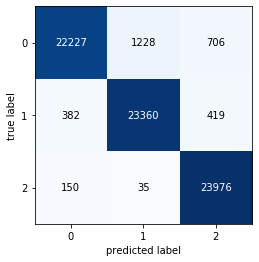

In [77]:
print("Accuracy Score: ", accuracy_sc(y_train_resampled, preds_train_resampled))
cm = confusion_matrix(y_train_resampled, preds_train_resampled)
plot_confusion_matrix(cm)
plt.show()

Accuracy Score:  0.9668181818181818


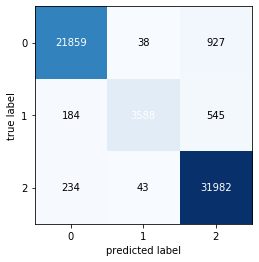

In [78]:
print("Accuracy Score: ", accuracy_sc(y, preds_X))
cm = confusion_matrix(y, preds_X)
plot_confusion_matrix(cm)
plt.show()

Accuracy Score:  0.9672053872053872


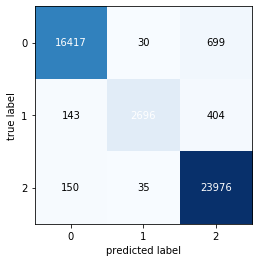

In [79]:
print("Accuracy Score: ", accuracy_sc(y_train, preds_train))
cm = confusion_matrix(y_train, preds_train)
plot_confusion_matrix(cm)
plt.show()

Accuracy Score:  0.9660606060606061


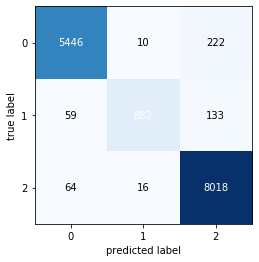

In [80]:
print("Accuracy Score: ", accuracy_sc(y_test, preds_test))
cm = confusion_matrix(y_test, preds_test)
plot_confusion_matrix(cm)
plt.show()

The above results seem good. So now we try and predict on the test data and then generate a csv for submission.

In [112]:
preds_main_test = predict(test)

In [113]:
submission_preds = pd.DataFrame(preds_main_test)

In [114]:
submission_preds.rename({0:'status_group'},axis = 1, inplace = True)

In [115]:
submission_preds['status_group'].value_counts()

2    8994
0    5384
1     472
Name: status_group, dtype: int64

In [116]:
submission_preds_mapped = submission_preds['status_group'].map({2: 'functional', 1: 'functional needs repair', 0: 'non functional'})
submission_preds_mapped.value_counts()

functional                 8994
non functional             5384
functional needs repair     472
Name: status_group, dtype: int64

In [117]:
submit_df = pd.concat([test_df['id'], submission_preds_mapped], axis = 1)
submit_df.rename(columns = {0: 'status_group'}, inplace = True)
submit_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [118]:
submit_df.to_csv('ultimate.csv', index = False )